In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv('./ErrorLog/errorlog0606_0612_edit_ver2.csv')
df.fillna('', inplace = True)   # 空值補 ''

print('Shape of the raw data: ', df.shape)

df.head(10)

Shape of the raw data:  (1005409, 16)


,EventTime,SessionID,UserID,ErrorEventID,Channel,Country,LV,VipLV,UDID,State,Machine,TotalBet,FeverState,PublishVer,CurChannel,IPCountry
0,1591694027,a98efd7aa8e5ca901f689caeee448a05,2.020100e+15,31419999,1,TW,999,8,"""49242BA5-2C92-43A9-A9AA-BB60517A0C2A""",,,,,,,
1,1591753912,c1c93c76a1273b6aa12751e3303e3db1,2.020100e+15,6001,1,CN,33,1,"""8FE31F29-49E0-4B64-BBBC-D9877C292968""",,,,,,,
2,1591753971,c1c93c76a1273b6aa12751e3303e3db1,2.020100e+15,9002,1,CN,33,1,"""8FE31F29-49E0-4B64-BBBC-D9877C292968""",,,,,,,
3,1591768171,"""""",2.020100e+15,2101,1,TW,1,0,"""C855F6DF-DA1A-4CCC-AC12-AA5574509E67""",,,,,,,
4,1591777553,8a6182354acf11f4bd71873be47778b4,2.020100e+15,6001,2,TW,999,8,13085a98dfaa3816,,,,,,,
5,1591711516,3d876fc03ce99a14ed5e71c0d7cb90e5,2.020100e+15,6001,2,TW,397,4,38d547b02d5d3710,,,,,,,
6,1591753763,6bc29aa385300d91541ced10f2061ad7,2.020100e+15,9002,1,TW,1000,8,"""3E1FFF13-AE55-4300-B66D-6CC18F673CF4""",,,,,,,
7,1591753737,6bc29aa385300d91541ced10f2061ad7,2.020100e+15,9002,1,TW,1000,8,"""3E1FFF13-AE55-4300-B66D-6CC18F673CF4""",,,,,,,
8,1591753711,6bc29aa385300d91541ced10f2061ad7,2.020100e+15,6001,1,TW,1000,8,"""3E1FFF13-AE55-4300-B66D-6CC18F673CF4""",,,,,,,
9,1591757540,3d116d8dacadac0094153cbab0bf7ceb,2.020100e+15,2254,1,TW,1000,8,"""3E1FFF13-AE55-4300-B66D-6CC18F673CF4""",,,,,,,


Shape of the raw data:  (169, 2)


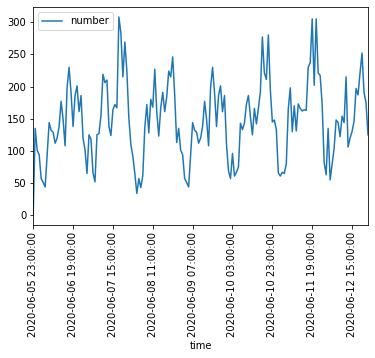

In [47]:
%matplotlib inline
from pandas.core.frame import DataFrame
from datetime import datetime

TW_EventTime = df.loc[df['IPCountry'] == "TW"]['EventTime']

date_time = []
for _time in TW_EventTime:
    dt = datetime.fromtimestamp(_time)

    # -----------------------將異常資料去除
    temp_time = str(datetime(dt.year, dt.month, dt.day))
    if temp_time == '2020-06-09 00:00:00':
        continue
    elif temp_time == '2020-06-06 00:00:00': # --------------6/9 補成 6/6
        time = str(datetime(dt.year, dt.month, 9, dt.hour))
        date_time.append(time)
        
    time = str(datetime(dt.year, dt.month, dt.day, dt.hour))
    date_time.append(time)
    
dic = {
    'time': date_time,
    'num': [1 for i in range(len(date_time))]
}
df_data = DataFrame(dic).groupby(by="time").count()
time = df_data.index.tolist()
number = df_data.num.tolist()

_df = pd.DataFrame()
_df['time'] = time
_df['number'] = number
_df.index = _df['time']
_df.plot(rot=90)

print('Shape of the raw data: ', _df.shape)

In [75]:
class HoltWinters:
    """Scikit-learn like interface for Holt-Winters method."""

    def __init__(self, season_len=6, alpha=0.5, beta=0.5, gamma=0.5):
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.season_len = season_len

    def fit(self, series):
        # note that unlike scikit-learn's fit method, it doesn't learn
        # the optimal model paramters, alpha, beta, gamma instead it takes
        # whatever the value the user specified the produces the predicted time
        # series, this of course can be changed.
        beta = self.beta
        alpha = self.alpha
        gamma = self.gamma
        season_len = self.season_len
        seasonals = self._initial_seasonal(series)

        # initial values
        predictions = []
        smooth = series[0]
        trend = self._initial_trend(series)
        predictions.append(smooth)

        for i in range(1, len(series)):
            value = series[i]
            previous_smooth = smooth
            seasonal = seasonals[i % season_len]
            smooth = alpha * (value - seasonal) + (1 - alpha) * (previous_smooth + trend)
            trend = beta * (smooth - previous_smooth) + (1 - beta) * trend
            seasonals[i % season_len] = gamma * (value - smooth) + (1 - gamma) * seasonal
            predictions.append(smooth + trend + seasonals[i % season_len])

        self.trend_ = trend
        self.smooth_ = smooth
        self.seasonals_ = seasonals
        self.predictions_ = predictions
        return self
    
    def _initial_trend(self, series):
        season_len = self.season_len
        total = 0.0
        for i in range(season_len):
            total += (series[i + season_len] - series[i]) / season_len

        trend = total / season_len
        return trend

    def _initial_seasonal(self, series):
        season_len = self.season_len
        n_seasons = len(series) // season_len

        season_averages = np.zeros(n_seasons)
        for j in range(n_seasons):
            start_index = season_len * j
            end_index = start_index + season_len
            season_average = np.sum(series[start_index:end_index]) / season_len
            season_averages[j] = season_average

        seasonals = np.zeros(season_len)
        seasons = np.arange(n_seasons)
        index = seasons * season_len
        for i in range(season_len):
            seasonal = np.sum(series[index + i] - season_averages) / n_seasons
            seasonals[i] = seasonal

        return seasonals

    def predict(self, n_preds=10):
        """
        Parameters
        ----------
        n_preds: int, default 10
            Predictions horizon. e.g. If the original input time series to the .fit
            method has a length of 50, then specifying n_preds = 10, will generate
            predictions for the next 10 steps. Resulting in a prediction length of 60.
        """
        predictions = self.predictions_
        original_series_len = len(predictions)
        for i in range(original_series_len, original_series_len + n_preds):
            m = i - original_series_len + 1
            prediction = self.smooth_ + m * self.trend_ + self.seasonals_[i % self.season_len]
            predictions.append(prediction)

        return predictions

In [86]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import Holt

def timeseries_cv_score(params, series, loss_function, season_len, n_splits=3):
    """
    Iterating over folds, train model on each fold's training set,
    forecast and calculate error on each fold's test set.
    """
    errors = []    
    alpha, beta, gamma = params
    time_series_split = TimeSeriesSplit(n_splits=n_splits) 

    for train, test in time_series_split.split(series):
        model = HoltWinters(season_len, alpha, beta, gamma)
        model.fit(series[train])

        # evaluate the prediction on the test set only
        predictions = model.predict(n_preds=len(test))
        test_predictions = predictions[-len(test):]
        test_actual = series[test]
        error = loss_function(test_actual, test_predictions)
        errors.append(error)

    return np.mean(errors)


x = [0, 0, 0]
season_len = 6
test_size = 20
data = _df['number']

# timeseries_cv_score(x, _df['number'], mean_squared_error)

opt = minimize(timeseries_cv_score, x0=x, 
               args=(data, mean_squared_log_error, season_len), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

original parameters: [0, 0, 0]
best parameters: [0.07618126 0.04898086 0.2369154 ]


In [89]:
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
pred = model.predict(n_preds=30)

print('original series length: ', len(data))
print('prediction length: ', len(pred))

original series length:  169
prediction length:  199


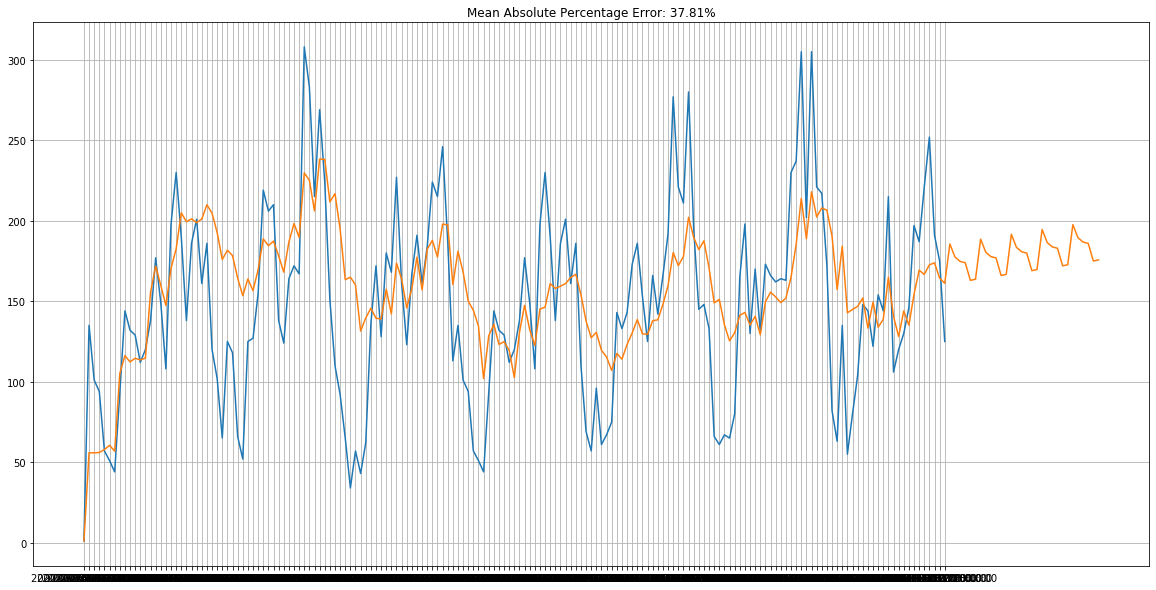

In [95]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error = mean_absolute_percentage_error(data, pred[:len(data)])

plt.figure(figsize=(20, 10))
plt.plot(data, label='Actual')
plt.plot(pred, label='Prediction')
plt.title(f'Mean Absolute Percentage Error: {error:.2f}%')
plt.grid(True)
plt.show()

C:\Users\HP AY111TX\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\HP AY111TX\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


11.964918135614585


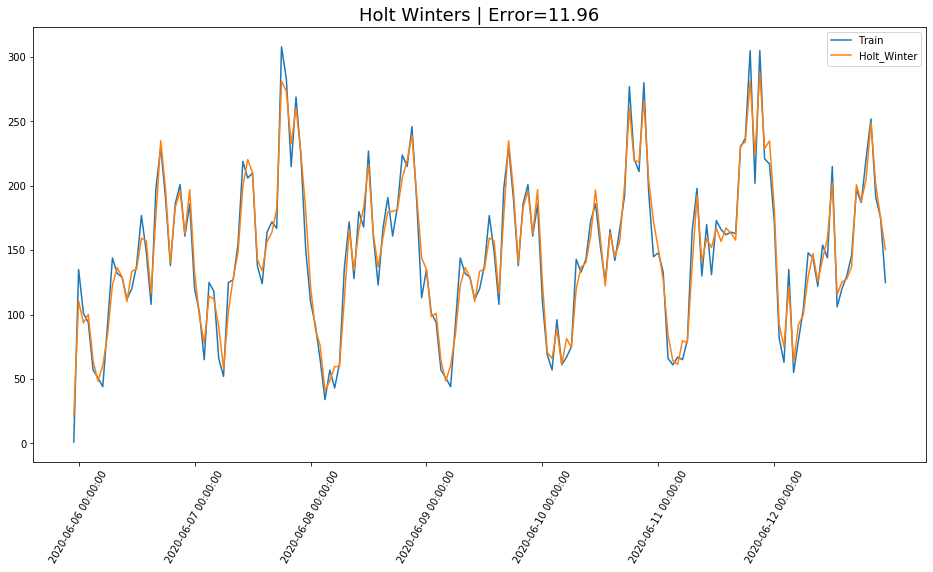

In [72]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import math
from sklearn.metrics import mean_squared_error

alpha = 0.07
beta = 0.05
gamma = 0.23

model = ExponentialSmoothing(np.asarray(_df['number']), seasonal_periods=6, trend='add', seasonal='add').fit()
# fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
pred = model.predict(start=1, end=len(_df))

rms = math.sqrt(mean_squared_error(_df['number'], pred))
print(rms)

plt.figure(figsize=(16,8))
plt.xticks(np.arange(1,168, 24.0), rotation=60)
plt.title(f'Holt Winters | Error={rms:.02f}',fontsize=18)
plt.plot(_df['number'], label='Train')
plt.plot(pred, label='Holt_Winter')
plt.legend(loc='best')
plt.show()